## Import all dependencies

In [1]:
import numpy as np
import pandas as pd
import sys
import scipy
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessRegressor
from numpy.linalg import cholesky, det, lstsq, inv
from scipy.spatial.distance import cdist
from scipy.optimize import minimize
from sklearn.model_selection import KFold
import time

sns.set_style('darkgrid')
np.random.seed(42)

## Set plotting styles

In [2]:
SMALL_SIZE = 18
MEDIUM_SIZE = 20
BIGGER_SIZE = 22

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

line_colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']

# Covariance functions

In [128]:
def SE(X1, X2, l, amp):
    '''
    SE covariance function. Computes 
    a covariance matrix from points in X1 and X2.
    
    Args:
        X1: Array of m points (m x d).
        X2: Array of n points (n x d).
        l : length scale
        amp: amplitude

    Returns:
        Covariance matrix (m x n).
    '''
    sqdist = cdist(X1, X2, 'sqeuclidean')
    val = (amp ** 2) * np.exp(-np.exp(np.log(0.5)- 2 * np.log(abs(l+0.0000001))) * sqdist) # amplitude as the sigma squared
    #val = amp * np.exp(-np.exp(np.log(0.5)- 2 * np.log(abs(l+0.0000000000001))) * sqdist) # amplitude as a whole
    return val

In [44]:
def Matern_3(xa, xb, mal):
     '''
    Matern covariance function with $\nu = 3/2$. Computes 
    a covariance matrix from points in xa and xb.
    
    Args:
        xa: Array of m points (m x d).
        xb: Array of n points (n x d).
        mal : length scale

    Returns:
        Covariance matrix (m x n).
    '''
    ma_dist = np.exp(0.5 * np.log(3) - np.log(abs(mal+0.00000001))) * cdist(xa, xb, 'euclidean')
    val = (1+ma_dist)*np.exp(-ma_dist)
    return val

In [45]:
def Gamma_exp(xa, xb, gaml): # set gamma = 1.5
    '''
    Gamma_exponential covariance function with $\gamma = 1.5$. Computes 
    a covariance matrix from points in xa and xb.
    
    Args:
        xa: Array of m points (m x d).
        xb: Array of n points (n x d).
        gaml : length scale

    Returns:
        Covariance matrix (m x n).
    '''
    gammaexp_dist = np.exp(-np.log(abs(gaml+0.00000001))) * cdist(xa, xb, 'euclidean')
    val = np.exp(-np.power(gammaexp_dist, 1.5))
    return val

# Training points

In [6]:
# define noise term 
noise = np.sqrt(0.5)
# Define the true function that we want to regress on
f_cos = lambda x: (np.cos(x)+x**2).flatten()

n1 = 60  # Number of training points
domain = (-6, 6) # domain of training points

np.random.seed(42)
X1 = np.linspace(domain[0], domain[1], n1).reshape(-1,1)
X2 = np.linspace(domain[0]-2, domain[1]+2, 90).reshape(-1,1)
yerr = np.random.normal(0,noise**2,n1) # gaussian noise 
Y1 = (f_cos(X1) + yerr).reshape(n1,1)
outliers = [-6,0,8] # x-axis of outliers

## Perturbations 

In [7]:
perturb1 = np.linspace(-30, 30,10,8) # perturbation on y-axis 10 points for every x
# define outliers_y a n x m matrix, n = len(outliers_x), m = len(perturb)
outliers_y1 = [[f_cos(outliers[i]) + _ for _ in perturb1] for i in range(len(outliers))]
outliers_x1 = [[outliers[i] for _ in perturb1] for i in range(len(outliers))]

## Compute Contaminated Training Set

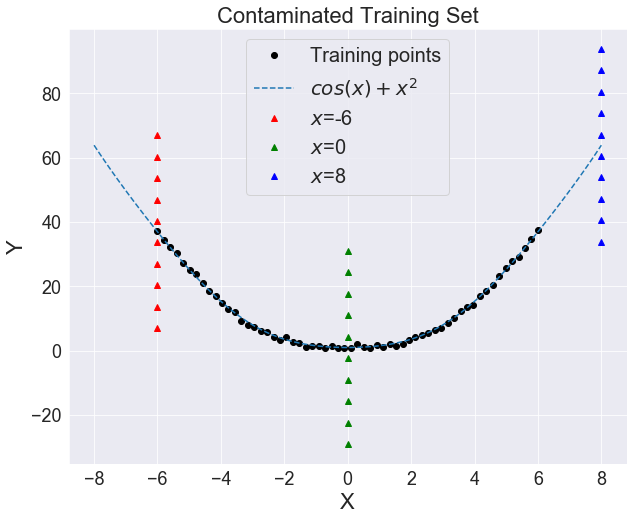

In [8]:
plt.figure(figsize=(10, 8))
label1 = '$cos(x)+x^2$'
plt.plot(X1,Y1,'ko',label='Training points')
plt.plot(X2,f_cos(X2),'--',label=label1)
labels = ['$x$='+str(i) for i in outliers]
for i in range(len(outliers)):
    plt.plot(outliers_x1[i],outliers_y1[i],'^', label=labels[i], c = line_colors[i])
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Contaminated Training Set')
plt.legend()

In [9]:
def nll_fn(X_train, Y_train, noise, para):
    '''
    Returns a function that computes the negative log marginal
    likelihood for training data X_train and Y_train and given 
    noise level. Here we implement Leave-one-out cross validation.
    
    Args:
        X_train: training locations (m x d).
        Y_train: training targets (m x 1).
        noise: known noise level of Y_train.
        para: input, for example,'l'(length scale) or 'amp'(amplitude) in SE.
        
    Returns:
        Minimization objective.
    '''
    def nll_naive(theta):
        '''
        args: theta, the parameter for which we want to find optimal value
        
        '''
       
        k_fold = KFold(len(X_train)) # Leave-one-out cross validation.
        f = 0
        for train_index, test_index in k_fold.split(X_train):
            x_train = X_train[train_index]
            y_train = Y_train[train_index]
            x_test = X_train[test_index]
            y_test = Y_train[test_index]
            
            if para == 'l':
                K = SE(x_train, x_train, l=theta, amp=1.0) + (noise**2) * np.eye(len(x_train))
                K_test = SE(x_test, x_train, l=theta, amp=1.0) 
                K_testtest = SE(x_test, x_test, l=theta, amp=1.0) 
            elif para == 'amp':
                K = SE(x_train, x_train, l = 0.8, amp=theta) + (noise**2) * np.eye(len(x_train))
                K_test = SE(x_test, x_train, l = 0.8, amp=theta) 
                K_testtest = SE(x_test, x_test, l = 0.8, amp=theta) 
            elif para == 'mal':
                K = Matern_3(x_train, x_train, mal=theta) + (noise**2) * np.eye(len(x_train))
                K_test = Matern_3(x_test, x_train, mal=theta) 
                K_testtest = Matern_3(x_test, x_test, mal=theta) 
            elif para == 'gaml':
                K = Gamma_exp(x_train, x_train, gaml=theta) + (noise**2) * np.eye(len(x_train))
                K_test = Gamma_exp(x_test, x_train, gaml=theta) 
                K_testtest = Gamma_exp(x_test, x_test, gaml=theta) 
            mu = (K_test @ inv(K)).dot(y_train) 
            cov = inv(K_testtest - K_test @ inv(K) @ K_test.T+0.000001)
            f = f + 0.5 * np.log(abs(cov)) + 0.5 * ((y_test - mu)**2) * cov + 0.5 * np.log(2*np.pi)
        return f
    return nll_naive
   



In [10]:
def grid_loocv(X_train, Y_train, noise, para, para_set):
    '''
    Returns the optimal parameter value using grid search.
    
    Args:
        X_train: training locations (m x d).
        Y_train: training targets (m x 1).
        noise: known noise level of Y_train.
        para: input, for example,'l'(length scale) or 'amp'(amplitude) in SE.
        para_set: the grid to search
        
    Returns:
        Optimal parameter value in the grid.
    '''
    nll_loo = 10000000000
    for val in para_set:
        temp = nll_fn(X_train, Y_train, noise, para)(val)
        if temp < nll_loo:
            l_opt = val
            nll_loo = temp
    return abs(l_opt)
    

## Implement Method 3

In [57]:
def sc_grid_loocv(x_train, y_train, noise, outliers_x, fun, para:str, para_set =[0.1,0.5,5,10,25,15,13,14,13.2,0.35] ):
    '''
    Returns Sensitivity Curve plots using leave-one-out cross validation with grid search 
    
    Args:
    outliers_x: the x-axis of outliers
    fun: the true function to generate training points
    para: receives a string, 'l' lengthscale, 'amp' amplitude
    method: LOO-CV corresponds to method = nll_fn by default or maximizing marginal likelihood method = neg_ll
    para_set: the grid to search
    
    '''
    tic = time.perf_counter()
    best = grid_loocv(x_train, y_train, noise, para, para_set)
    perturb = np.linspace(-30, 30,10,8) # perturbation on y-axis
    # define outliers_y a n x m matrix, n = len(outliers_x), m = len(perturb)
    outliers_y = [[fun(outliers_x[i]) + _ for _ in perturb] for i in range(len(outliers_x))]
    # define var matrix the same size as outliers_y to store optimum values for each case
    #var_opt = [[0 for _ in range(len(perturb))] for _ in range(len(outliers_x))]
    var_opt = [[0]*len(perturb) for _ in range(len(outliers_x))]
    for i in range(len(outliers_x)):
        outlier_x = np.array([outliers_x[i]]).reshape(1, -1)
        X_train = np.append(x_train, outliers_x[i]).reshape(len(x_train)+1,1) # with the outlier
        for j in range(len(perturb)):
            Y_train = np.append(y_train, outliers_y[i][j]).reshape(len(y_train)+1,1)
            var_opt[i][j] = grid_loocv(X_train, Y_train, noise, para, para_set)
            
    plt.figure(figsize=(10, 8))
    labels = ['$x_0$='+str(i) for i in outliers_x]
    for i in range(len(outliers_x)):
        plt.plot(perturb, np.log(abs(var_opt[i] - best)), '-', marker='o', label=labels[i], c = line_colors[i])
    plt.xlabel('$y_{outlier} - f(x_0)$')
    plt.ylabel('$log(|SC(x_0)|)$')
    plt.ylim(2,10)
    #plt.title('Sensitivity Curve of '+ para +' \n by Leave-one-out Cross Validation with Grid Search')
    #plt.title('Sensitivity Curve of Amplitude in SE by Method 3')
    plt.legend()
    print(var_opt)
    toc = time.perf_counter()
    print(f"Finish the implementation in {toc - tic:0.4f} seconds")

## Length scale in SE

[[0.41379310344827586, 0.48275862068965514, 0.6206896551724138, 0.7586206896551724, 0.7586206896551724, 0.7586206896551724, 0.6206896551724138, 0.5517241379310345, 0.41379310344827586, 0.3448275862068966], [0.27586206896551724, 0.3448275862068966, 0.41379310344827586, 0.5517241379310345, 0.7586206896551724, 0.7586206896551724, 0.5517241379310345, 0.41379310344827586, 0.3448275862068966, 0.27586206896551724], [1.4482758620689655, 1.5862068965517242, 1.6551724137931034, 1.6551724137931034, 1.6551724137931034, 1.6551724137931034, 1.5862068965517242, 1.5172413793103448, 1.4482758620689655, 1.3793103448275863]]
Finish the implementation in 18.3207 seconds


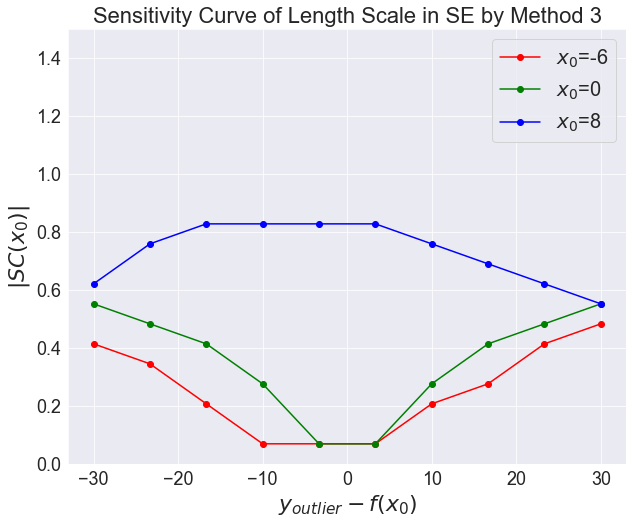

In [54]:
sc_grid_loocv(X1, Y1, noise, outliers, f_cos, 'l', para_set = np.linspace(0,2,30)) # Leave-one-out cv

Amplitude in SE

[[9263.819095477387, 9263.819095477387, 9263.819095477387, 9263.819095477387, 8977.386934673366, 8977.386934673366, 9263.819095477387, 9263.819095477387, 9263.819095477387, 9263.819095477387], [9304.020100502512, 9304.020100502512, 9304.020100502512, 9304.020100502512, 9198.492462311558, 9198.492462311558, 9304.020100502512, 9304.020100502512, 9304.020100502512, 9304.020100502512], [9047.738693467336, 9047.738693467336, 9047.738693467336, 9047.738693467336, 9047.738693467336, 9047.738693467336, 9047.738693467336, 9047.738693467336, 9047.738693467336, 9047.738693467336]]
Finish the implementation in 114.4376 seconds


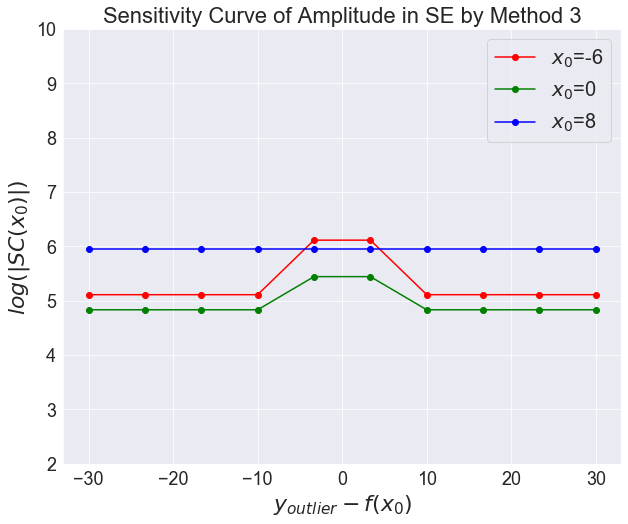

In [58]:
sc_grid_loocv(X1, Y1, noise, outliers, f_cos, 'amp', para_set = np.linspace(8500,9500,200)) # Leave-one-out cv

## Length scale in Matern with \nu = 3/2

[[0.5172413793103449, 0.6206896551724138, 0.8275862068965517, 0.9310344827586207, 1.0344827586206897, 0.9310344827586207, 0.8275862068965517, 0.6206896551724138, 0.5172413793103449, 0.5172413793103449], [0.3103448275862069, 0.41379310344827586, 0.5172413793103449, 0.7241379310344828, 1.0344827586206897, 1.0344827586206897, 0.7241379310344828, 0.5172413793103449, 0.41379310344827586, 0.3103448275862069], [1.7586206896551724, 1.8620689655172413, 1.9655172413793103, 2.0689655172413794, 2.0689655172413794, 1.9655172413793103, 1.9655172413793103, 1.8620689655172413, 1.7586206896551724, 1.6551724137931034]]
Finish the implementation in 16.9499 seconds


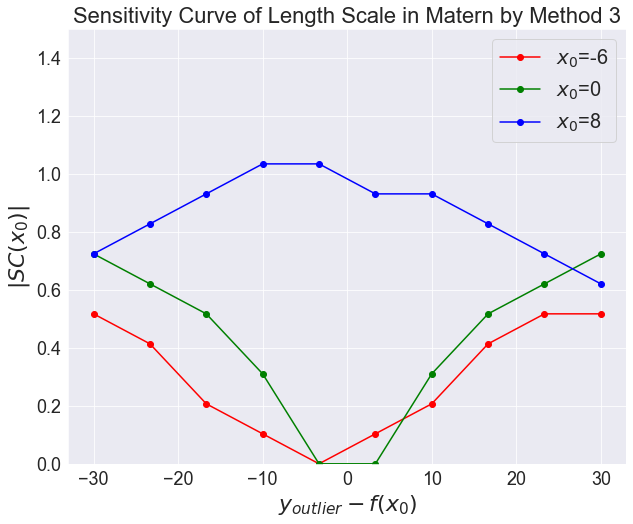

In [52]:
sc_grid_loocv(X1, Y1, noise, outliers, f_cos, 'mal', para_set = np.linspace(0,3,30)) # Leave-one-out cv

## Length scale in Gamma_exponential with \gamma = 1.5

[[0.7346938775510203, 0.8571428571428571, 1.0408163265306123, 1.2244897959183674, 1.2857142857142856, 1.2244897959183674, 1.0408163265306123, 0.8571428571428571, 0.7346938775510203, 0.6122448979591837], [0.42857142857142855, 0.5510204081632653, 0.7346938775510203, 0.9795918367346939, 1.2857142857142856, 1.2857142857142856, 1.0408163265306123, 0.7346938775510203, 0.5510204081632653, 0.42857142857142855], [2.2653061224489797, 2.4489795918367347, 2.571428571428571, 2.63265306122449, 2.63265306122449, 2.571428571428571, 2.4489795918367347, 2.387755102040816, 2.2653061224489797, 2.142857142857143]]
Finish the implementation in 34.0702 seconds


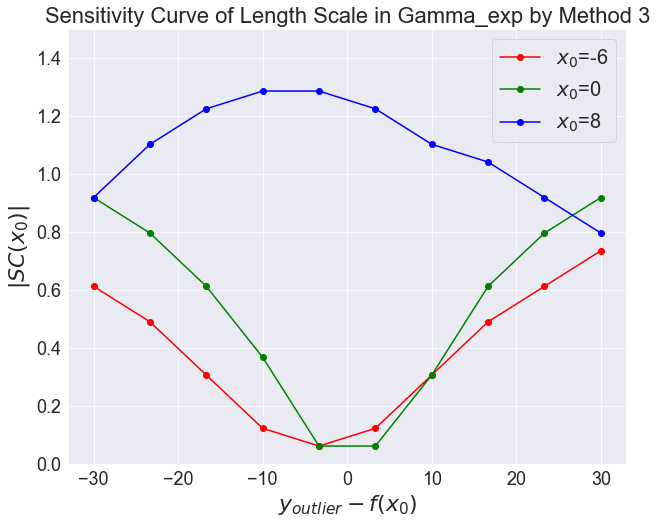

In [50]:
sc_grid_loocv(X1, Y1, noise, outliers, f_cos, 'gaml', para_set = np.linspace(0,3,50)) # Leave-one-out cv

In [59]:
def nll(X_train, Y_train, noise, para, value):
    '''
    Returns the negative log-marginal likelihood function value for the given parameters
    
    Args:
    para: receives a string, 'l','mal','gaml' all refer to lengthscale, 'amp' amplitude
    method: LOO-CV corresponds to method = nll_fn by default or maximizing marginal likelihood method = neg_ll
    value: given value for the parameter
    
    Returns:
    A value.
    '''
    if para == 'l':
        K = SE(X_train, X_train, l = value, amp=1.0) + (noise**2) * np.eye(len(X_train))
    elif para == 'amp':
        K = SE(X_train, X_train, l = 0.8, amp = value) + (noise**2) * np.eye(len(X_train))
    elif para == 'mal':
        K = Matern_3(X_train, X_train, mal = value) + (noise**2) * np.eye(len(X_train))
    elif para == 'gaml':
        K = Gamma_exp(X_train, X_train, gaml = value) + (noise**2) * np.eye(len(X_train))
    f = 0.5 * np.log(abs(det(K))) + 0.5 * Y_train.T.dot(inv(K).dot(Y_train)) + 0.5 * len(X_train) * np.log(2*np.pi)
    return f

In [60]:
def neg_ll(X_train, Y_train, noise, para):
    '''
    Returns a function that computes the negative log marginal
    likelihood for training data X_train and Y_train and given 
    noise level.
    
    Args:
    para: receives a string, 'l','mal','gaml' all refer to length scale, 'amp' amplitude
    method: LOO-CV corresponds to method = nll_fn by default or maximizing marginal likelihood method = neg_ll
    value: given value for the parameter
    
    Returns:
        A function to minimize.
    '''
    def nll_naive(theta):
        """
        Args: 
        theta: the parameter to be seen as unknown and to be minmizised on
        """
        if para == 'l':
            K = SE(X_train, X_train, l=theta, amp=1.0) + (noise**2) * np.eye(len(X_train))      
        elif para == 'amp':
            K = SE(X_train, X_train, l = 0.8, amp=theta) + (noise**2) * np.eye(len(X_train))
        elif para == 'mal':
            K = Matern_3(X_train, X_train, mal = theta) + (noise**2) * np.eye(len(X_train))
        elif para == 'gaml':
            K = Gamma_exp(X_train, X_train, gaml = theta) + (noise**2) * np.eye(len(X_train))
        f = 0.5 * np.log(det(K)+0.00000001) + 0.5 * Y_train.T.dot(inv(K).dot(Y_train)) + 0.5 * len(X_train) * np.log(2*np.pi)
        return f
    return nll_naive



In [61]:
def optimum(x_train, y_train, noise, para, para_set, method1):
    '''
    We use minimize function to help find the optimum.
    This function helps us to run minimize several times for different initial values to avoid local optimums
    Returns the optimum value for given values.
    
    Args:
    para_set: initial values for minimization functions to avoid local optimua
    method1: the optimization method
    
    Returns:
    The optimal value for the parameter
    
    '''
    ll_min = 10000000000
    l_optimum = 0
    for i in para_set:
        res = minimize(method1(x_train, y_train, noise, para), [i], method='L-BFGS-B')
        negll = neg_ll(x_train, y_train, noise, para)(res.x)
        if ll_min > negll:
            l_optimum = res.x
            ll_min = negll
           
    return abs(l_optimum)

In [62]:
optimum(X1, Y1, noise, 'l', [0.1,0.5,5,1], neg_ll)

array([1.60549354])

# plot Sensitivity curves for LOO-CV method
# obj: marginal likelihood

In [84]:
def sc_loocv(x_train, y_train, noise, outliers_x, fun, para:str, method1=nll_fn,para_set =[0.1,0.5,5,10,25,15,13,14,13.2,0.35] ):
    '''
    Returns Sensitivity Curve plots using leave-one-out cross validation
    
    Args:
    fun: the true function to generate training points
    para: receives a string, 'l','mal','gaml' all refer to length scale, 'amp' amplitude
    method1: LOO-CV corresponds to method = nll_fn by default and maximizing marginal likelihood method = neg_ll
    para_set: initial values for minimization functions to avoid local optimua
    
    '''
    tic = time.perf_counter()
    best = optimum(x_train, y_train, noise, para, para_set, method1)
    perturb = np.linspace(-30, 30,10,8) # perturbation on y-axis
    # define outliers_y a n x m matrix, n = len(outliers_x), m = len(perturb)
    outliers_y = [[fun(outliers_x[i]) + _ for _ in perturb] for i in range(len(outliers_x))]
    # define var matrix the same size as outliers_y to store optimum values for each case
    #var_opt = [[0 for _ in range(len(perturb))] for _ in range(len(outliers_x))]
    var_opt = [[0]*len(perturb) for _ in range(len(outliers_x))]
    for i in range(len(outliers_x)):
        outlier_x = np.array([outliers_x[i]]).reshape(1, -1)
        X_train = np.append(x_train, outliers_x[i]).reshape(len(x_train)+1,1) # with the outlier
        for j in range(len(perturb)):
            Y_train = np.append(y_train, outliers_y[i][j]).reshape(len(y_train)+1,1)
            var_opt[i][j] = optimum(X_train, Y_train, noise, para, para_set, method1)
            
    plt.figure(figsize=(10, 8))
    labels = ['$x_0$='+str(i) for i in outliers_x]
    for i in range(len(outliers_x)):
        plt.plot(perturb, np.log(abs(var_opt[i] - best)), '-', marker='o', label=labels[i], c = line_colors[i])
    plt.xlabel('$y_{outlier} - f(x_0)$')
    plt.ylabel('$log(|SC(x_0)|)$')
    if method1 == nll_fn:
        #plt.title('Sensitivity Curve of '+ para +' \n by Leave-one-out Cross Validation')
        plt.title('Sensitivity Curve of Amplitude in SE by Method 2')
    else:
        #plt.title('Sensitivity Curve of '+ para +' \n by Maximizing Marginal Likelihood')
        plt.title('Sensitivity Curve of Amplitude in SE by Method 1')
    #plt.ylim(-500, 800)
    #plt.xlim(-15, 15)
    plt.ylim(0, 10)
    plt.legend()
    print(var_opt)
    toc = time.perf_counter()
    print(f"Finish the implementation in {toc - tic:0.4f} seconds")

## SE covariance function using Method 2
## length scale

[[array([0.43007151]), array([0.5072449]), array([0.62036641]), array([0.73511686]), array([0.78298314]), array([0.74630333]), array([0.63918609]), array([0.51916621]), array([0.43484731]), array([0.36807741])], [array([0.2736604]), array([0.33122323]), array([0.42453345]), array([0.56950566]), array([0.76849153]), array([0.77371219]), array([0.58486929]), array([0.42945602]), array([0.34276595]), array([0.28347872])], [array([1.44356656]), array([1.55992833]), array([1.63724692]), array([1.67498304]), array([1.66966103]), array([1.62454151]), array([1.55873003]), array([1.49012939]), array([1.42557819]), array([1.36749504])]]
Finish the implementation in 70.2467 seconds


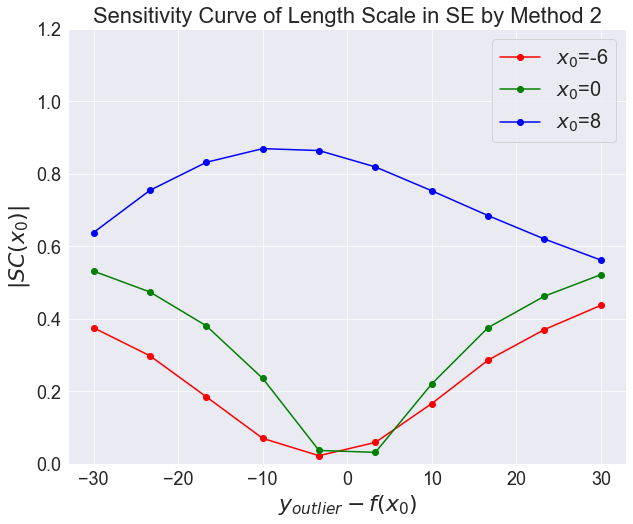

In [68]:
sc_loocv(X1, Y1, noise, outliers, f_cos, 'l', nll_fn, para_set = [0.1,0.2,0.5,0.8,1.2,2]) # Leave-one-out cv

In [ ]:
# x=8 the green line is far away from the bulk of data, gp gives unreliable predictions. other lines are nearly
# symmetric
# 

## SE covariance function using Method 1
## length scale

[[array([1.49724704]), array([1.54775272]), array([1.5821092]), array([1.60141369]), array([1.60672986]), array([1.59902817]), array([1.57905992]), array([1.54725897]), array([1.50384189]), array([1.44930057])], [array([1.48218289]), array([1.51677895]), array([1.54772715]), array([1.5747969]), array([1.59697111]), array([1.61253984]), array([1.61911823]), array([1.61316297]), array([1.58739005]), array([1.51905949])], [array([2.05005223]), array([2.15237516]), array([2.22547094]), array([2.27016343]), array([2.2858794]), array([2.27155786]), array([2.22741798]), array([2.15790361]), array([2.073068]), array([1.98337814])]]
Finish the implementation in 0.6891 seconds


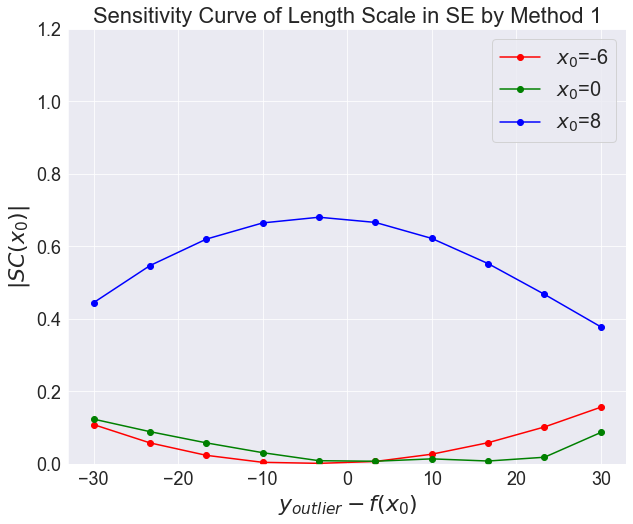

In [69]:
sc_loocv(X1, Y1, noise, outliers, f_cos, 'l', method1=neg_ll, para_set = [0.1,0.2,0.5,0.8,1.2,2]) # maximizing marginal likelihood function

In [ ]:
# not so robust 

## SE covariance function using method 2 
## Amplitude 

In [131]:
def SE(X1, X2, l, amp):
    '''
    SE covariance function. Computes 
    a covariance matrix from points in X1 and X2.
    
    Args:
        X1: Array of m points (m x d).
        X2: Array of n points (n x d).
        l : length scale
        amp: amplitude

    Returns:
        Covariance matrix (m x n).
    '''
    sqdist = cdist(X1, X2, 'sqeuclidean')
    #val = (amp ** 2) * np.exp(-np.exp(np.log(0.5)- 2 * np.log(abs(l+0.0000001))) * sqdist) # amplitude as the sigma squared
    val = amp * np.exp(-np.exp(np.log(0.5)- 2 * np.log(abs(l+0.0000000000001))) * sqdist) # amplitude as a whole
    return val

[[array([288.0057055]), array([126.77817087]), array([236.74663796]), array([185.18908722]), array([191.14536112]), array([241.53052359]), array([252.55330602]), array([144.89809284]), array([1019.38964415]), array([346.95811596])], [array([203.85171556]), array([1557.54853563]), array([251.0788838]), array([353.59765751]), array([157.84891332]), array([148.80026105]), array([187.84906651]), array([227.03427571]), array([240.98763408]), array([1269.35567052])], [array([529.53283132]), array([875.64831274]), array([265.16351382]), array([356.14987727]), array([317.43363143]), array([331.67436564]), array([421.00202035]), array([447.50072429]), array([654.99551405]), array([550.35944425])]]
Finish the implementation in 208.2521 seconds


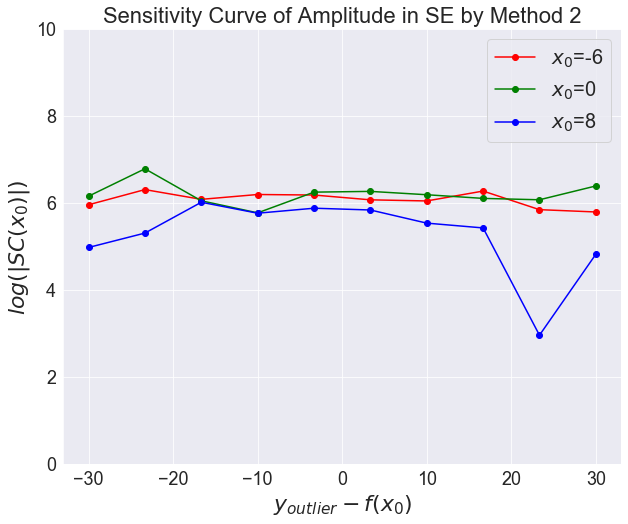

In [87]:
sc_loocv(X1, Y1, noise, outliers, f_cos, 'amp',para_set=[13,14.5,15,10], method1 = nll_fn)

In [81]:
#sc_loocv(X1, Y1, noise, outliers, f_cos, 'amp',para_set=[13,14.5,15,10], method1 = nll_fn)
## error: singular matrix

## SE covariance function using Method 1
## Amplitude 

[[array([431.10799407]), array([250.56518524]), array([183.52269486]), array([162.39534028]), array([166.70153649]), array([194.41764789]), array([255.50209871]), array([377.71687023]), array([0.21205327]), array([1110.63745497])], [array([853.57505485]), array([377.84681852]), array([248.25333309]), array([198.13576653]), array([178.88441716]), array([178.75709312]), array([198.18343378]), array([250.89358851]), array([390.51939626]), array([829.97947319])], [array([211.70182882]), array([231.88098597]), array([255.67130878]), array([283.06494583]), array([314.06534738]), array([348.55380424]), array([386.55395827]), array([427.99035418]), array([472.92037669]), array([521.23071697])]]
Finish the implementation in 2.4549 seconds


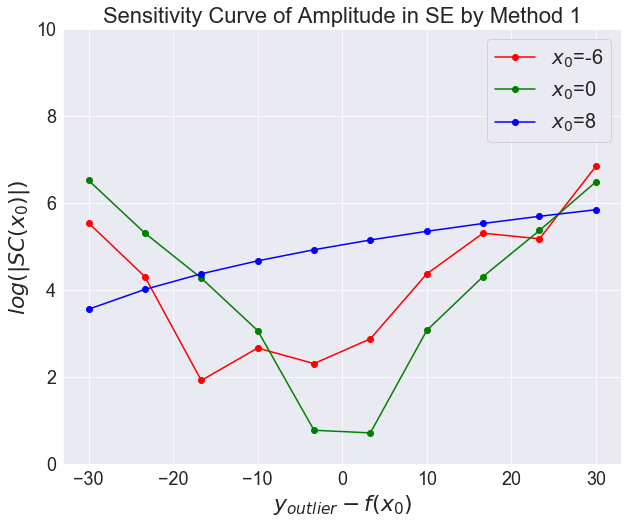

In [85]:
# sigma ^ 2 as parameter
sc_loocv(X1, Y1, noise, outliers, f_cos, 'amp',para_set=[10,13.5,13.8,14,16],method1=neg_ll)

## Matern covariance function using Method 2
## length scale

[[array([0.56068059]), array([0.657747]), array([0.78577613]), array([0.92232314]), array([0.99231358]), array([0.9378332]), array([0.79903503]), array([0.65670766]), array([0.54772529]), array([0.47056696])], [array([0.33772062]), array([0.42311394]), array([0.55078596]), array([0.74952827]), array([0.98221393]), array([0.98860826]), array([0.76345446]), array([0.56173577]), array([0.42948805]), array([0.34006285])], [array([1.73417391]), array([1.88202884]), array([1.98734462]), array([2.041168]), array([2.04380666]), array([2.00479462]), array([1.93906971]), array([1.86126147]), array([1.78181427]), array([1.70646298])]]
Finish the implementation in 67.2200 seconds


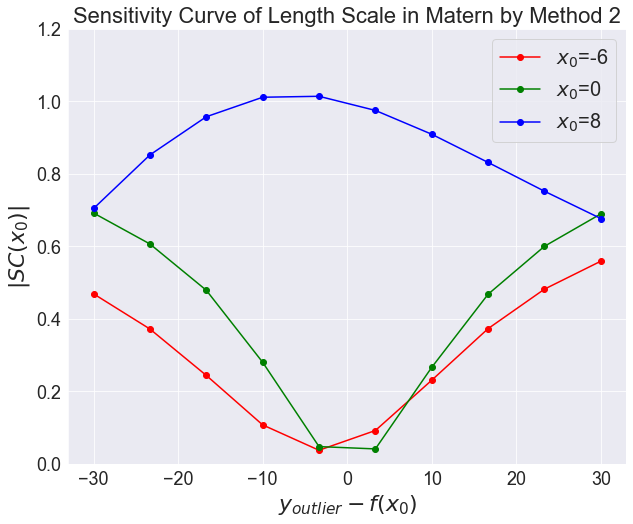

In [71]:
sc_loocv(X1, Y1, noise, outliers, f_cos, 'mal',nll_fn, para_set=[0.5,0.8,1,1.2,2.1,2.2])

## Matern covariance function with Method 1
## length scale

[[array([1.83621915]), array([1.89821115]), array([1.93819584]), array([1.95679303]), array([1.95521132]), array([1.93495374]), array([1.89767012]), array([1.84510391]), array([1.77908621]), array([1.70150364])], [array([1.77430381]), array([1.84968094]), array([1.90500735]), array([1.94069017]), array([1.95713015]), array([1.95464348]), array([1.93341312]), array([1.89348414]), array([1.83481281]), array([1.75736593])], [array([2.47672124]), array([2.5971532]), array([2.67902571]), array([2.72016362]), array([2.72263915]), array([2.691594]), array([2.63403104]), array([2.55767849]), array([2.4699767]), array([2.37729108])]]
Finish the implementation in 0.6591 seconds


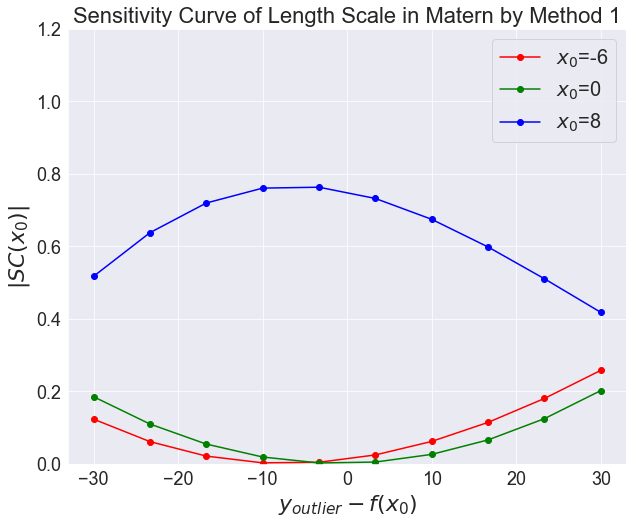

In [72]:
sc_loocv(X1, Y1, noise, outliers, f_cos, 'mal', method1=neg_ll, para_set=[0.5,0.8,1,1.4,2.1,2.2])

## Gamma_exponential covariance function using Method 1
## lengthscale 

[[array([2.29058455]), array([2.36188875]), array([2.40777874]), array([2.42917487]), array([2.42755444]), array([2.40471417]), array([2.36259311]), array([2.30316069]), array([2.22834051]), array([2.13998706])], [array([2.21503676]), array([2.30565622]), array([2.37121206]), array([2.41249318]), array([2.43030943]), array([2.42542131]), array([2.3984848]), array([2.34999946]), array([2.28023152]), array([2.18905516])], [array([3.05737084]), array([3.20223025]), array([3.3010501]), array([3.35229017]), array([3.35898036]), array([3.32709157]), array([3.26421412]), array([3.17851814]), array([3.0779122]), array([2.96938324])]]
Finish the implementation in 0.8242 seconds


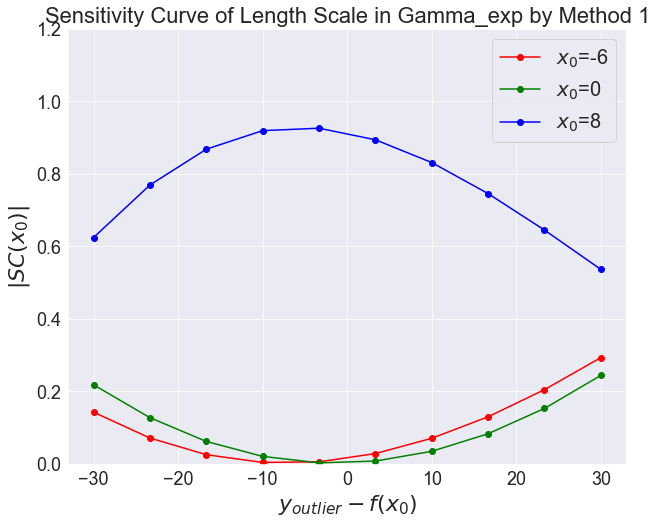

In [77]:
sc_loocv(X1, Y1, noise, outliers, f_cos, 'gaml', method1=neg_ll, para_set=[0.5,1.0,1.5,1.7,2.4,2.5])

## Gamma_exponential covariance function using Method 2
## lengthscale 

[[array([0.74061291]), array([0.87300883]), array([1.0430448]), array([1.21620535]), array([1.30073828]), array([1.23255282]), array([1.05924015]), array([0.87742587]), array([0.73382646]), array([0.62916644])], [array([0.45256452]), array([0.56477813]), array([0.73725959]), array([1.00518047]), array([1.29515258]), array([1.29811695]), array([1.01674495]), array([0.74776854]), array([0.57153293]), array([0.45676268])], [array([2.24729362]), array([2.42697982]), array([2.55165235]), array([2.61187324]), array([2.60906704]), array([2.55481428]), array([2.4667689]), array([2.36279255]), array([2.25641253]), array([2.15553454])]]
Finish the implementation in 61.8072 seconds


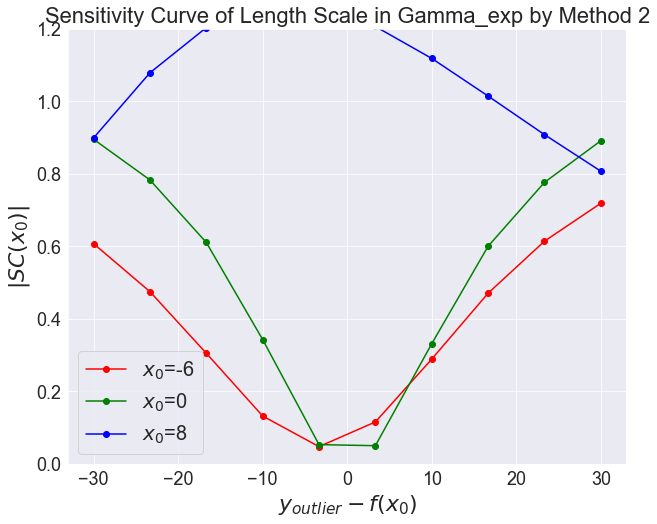

In [78]:
sc_loocv(X1, Y1, noise, outliers, f_cos, 'gaml', method1=nll_fn, para_set=[0.5,1.0,1.5,2.4,2.5])

## Get GP predictions

In [88]:
def gp_pred(x_train,y_train,x_test, noise, para, val):
    '''
    This function computes the posterior predictive mean 
    
    Args:
    
    Same as above.
     
    Returns:
    
    The mean vector
    
    '''
    if para == 'l':
        K = inv(SE(x_train, x_train, l = val, amp=1.0) + noise**2 * np.eye(len(x_train)))
        ker_test = SE(x_test, x_train, l = val, amp=1.0)
    elif para == 'amp':
        K = inv(SE(x_train, x_train, l = 0.8, amp = val) + noise**2 * np.eye(len(x_train)))
        ker_test = SE(x_test, x_train, l = 0.8, amp = val)
    elif para == 'mal':
        K = inv(Matern_3(x_train, x_train, mal = val) + noise**2 * np.eye(len(x_train)))
        ker_test = Matern_3(x_test, x_train, mal = val)
    elif para == 'gaml':
        K = inv(Gamma_exp(x_train, x_train, gaml = val) + noise**2 * np.eye(len(x_train)))
        ker_test = Gamma_exp(x_test, x_train, gaml = val)
    mu = (ker_test @ K).dot(y_train)
    return mu

In [89]:
def kfoldcv(X, Y, k, noise, para, value):
    '''
    This function computes the MSE using k-fold cross validaon
    
    Args:
    
    Same as above.
    
    Returns:
    
    MSE value.
    
    '''
    
    k_fold = KFold(n_splits=k,random_state=None, shuffle=False)
    mse =[]

    for train_index, test_index in k_fold.split(X):
        x_train = X[train_index]
        y_train = Y[train_index]
        x_test  = X[test_index]
        y_test  = Y[test_index]
        
        pred = gp_pred(x_train,y_train,x_test, noise,para,value)
        mse.append(np.sum((y_test - pred)**2)/len(y_test))
    #print(mse)
    return np.mean(mse)
    

# Grid search 

In [90]:
def gp_grid_search(X_train, Y_train, noise, k, para, para_set):
    '''
    This function implement grid search with given list of parameters
    
    Args:
    
    k: k_fold 
    para_set: possible parameter values for grid search
    
    Returns:
    
    The optimal value (when the MSE is at minimium) and the loss
    
    '''
    loss = 100000000
    l_opt = 0
    for val in para_set:
        temp = kfoldcv(X_train, Y_train, k, noise, para, val)
        if temp < loss:
            loss = temp
            l_opt = val
    return l_opt, loss

## Plot Sensitivity Curves with Method 5


In [109]:
def sc_kfold_cv(x_train, y_train, noise, outliers_x:list, fun, k, para:str, para_set = [0.8,0.82,0.84,0.86,0.88]):
    '''
    This function uses k_fold cross validation (Method 5) to plot Sensitivity Curve
    
    Args:
    
    outliers_x: possible x values for outliers
    fun: true function of generating training points
    noise: noise term added to training points, variance of normal distribution
    
    '''
    tic = time.perf_counter()
    best = gp_grid_search(x_train, y_train, noise, k, para, para_set)[0]
    perturb = np.linspace(-30, 30,10,8)
    outliers_y = [[fun(outliers_x[i]) + _ for _ in perturb] for i in range(len(outliers_x))]    
    var_opt = [[0 for _ in range(len(perturb))] for _ in range(len(outliers_x))]
    for i in range(len(outliers_x)):
        outlier_x = np.array([outliers_x[i]]).reshape(1, -1)
        X_train = np.append(x_train, outliers_x[i]).reshape(len(x_train)+1,1)
        for j in range(len(perturb)):
            Y_train = np.append(y_train, outliers_y[i][j]).reshape(len(y_train)+1,1)
            var_opt[i][j] = gp_grid_search(X_train, Y_train, noise, k, para, para_set)[0]
            
    # plot the results
    plt.figure(figsize=(10, 8))
    labels = ['$x_0$='+str(i) for i in outliers_x]
    for i in range(len(outliers_x)):
        plt.plot(perturb, np.log(abs(var_opt[i]-best)), '-',marker='o', label=labels[i], c = line_colors[i])
    plt.xlabel('$y_{outlier} - f(x_0)$')
    plt.ylabel('$log(|SC(x_0)|)$')
    #plt.ylabel('$|SC(x_0)|$')
    #plt.title('Sensitivity Curve of ' + para + '\n by '+ str(k) +'-fold Cross Validation')
    plt.title('Sensitivity Curve of Amplitude in SE' + '\n by Method 5 with k=' +str(k))
    plt.ylim(0,10)
    plt.legend()
    print(var_opt)
    toc = time.perf_counter()
    print(f"Finish the implementation in {toc - tic:0.4f} seconds")

In [206]:
gp_grid_search(X1, Y1, noise, 6, 'l', np.linspace(2, 6, 100))[0]

5.070707070707071

## SE covariance function using Method 5
## length scale

[[4.363636363636363, 4.303030303030303, 4.303030303030303, 4.363636363636363, 4.363636363636363, 4.424242424242424, 4.545454545454545, 4.666666666666667, 4.787878787878788, 4.96969696969697], [4.424242424242424, 4.363636363636363, 4.363636363636363, 4.363636363636363, 4.363636363636363, 4.363636363636363, 4.424242424242424, 4.424242424242424, 4.424242424242424, 4.424242424242424], [4.424242424242424, 4.484848484848484, 4.545454545454545, 4.6060606060606055, 4.666666666666667, 4.7272727272727275, 4.787878787878788, 4.787878787878788, 4.848484848484849, 4.909090909090909]]
Finish the implementation in 2.1200 seconds


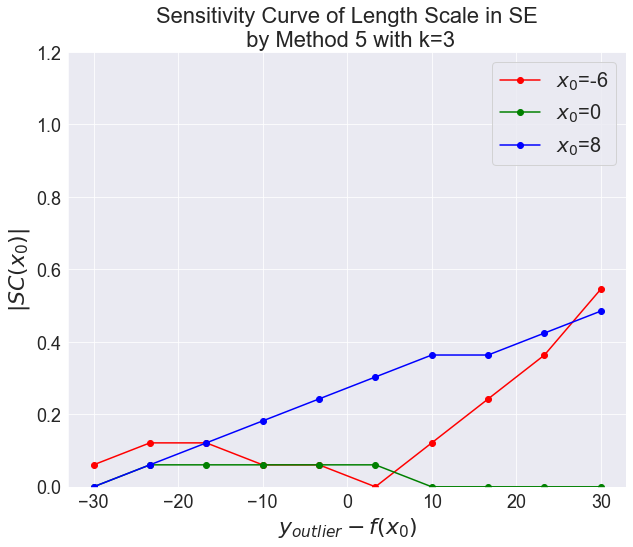

In [98]:
sc_kfold_cv(X1, Y1, noise, outliers, f_cos, 3, 'l',para_set=np.linspace(2, 8, 100))

## SE covariance function using Method 5
## length scale

[[5.090909090909091, 5.03030303030303, 4.96969696969697, 2.3636363636363638, 2.3636363636363638, 2.4242424242424243, 2.4242424242424243, 2.484848484848485, 2.606060606060606, 4.96969696969697], [5.03030303030303, 5.03030303030303, 5.03030303030303, 5.03030303030303, 5.03030303030303, 5.090909090909091, 5.090909090909091, 5.090909090909091, 5.151515151515151, 5.151515151515151], [5.151515151515151, 5.212121212121213, 5.272727272727273, 5.333333333333334, 5.3939393939393945, 5.454545454545455, 5.515151515151516, 5.575757575757576, 5.636363636363637, 5.696969696969697]]
Finish the implementation in 3.9706 seconds


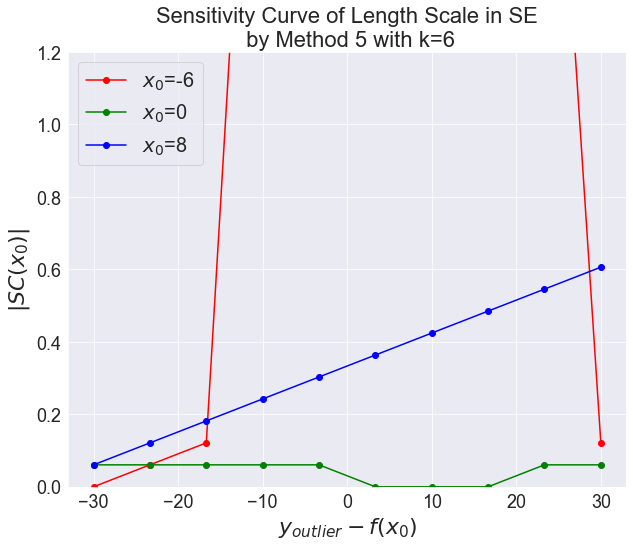

In [99]:
sc_kfold_cv(X1, Y1, noise, outliers, f_cos, 6, 'l',para_set=np.linspace(2, 8, 100))

## SE covariance function using Method 5
## length scale

[[5.151515151515151, 5.090909090909091, 2.4242424242424243, 2.3636363636363638, 2.303030303030303, 2.303030303030303, 2.303030303030303, 2.3636363636363638, 2.484848484848485, 2.5454545454545454], [5.03030303030303, 5.03030303030303, 5.03030303030303, 5.090909090909091, 5.090909090909091, 2.5454545454545454, 2.5454545454545454, 2.5454545454545454, 2.5454545454545454, 2.5454545454545454], [5.212121212121213, 5.272727272727273, 5.3939393939393945, 5.515151515151516, 5.575757575757576, 5.696969696969697, 5.757575757575758, 5.818181818181818, 5.878787878787879, 5.9393939393939394]]
Finish the implementation in 6.5938 seconds


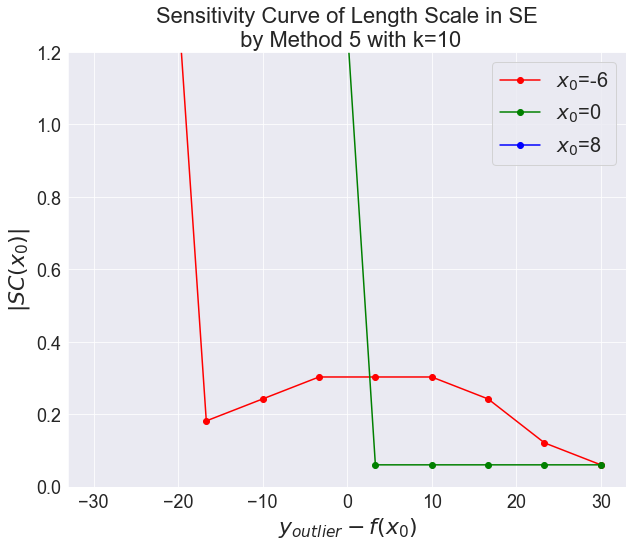

In [100]:
sc_kfold_cv(X1, Y1, noise, outliers, f_cos, 10, 'l', para_set=np.linspace(2, 8, 100))

## SE covariance function using Method 5
## amplitude

[[11.030150753768844, 11.030150753768844, 11.030150753768844, 10.65326633165829, 10.27638190954774, 9.899497487437186, 9.522613065326635, 8.768844221105528, 5.0, 5.0], [6.884422110552764, 7.63819095477387, 8.391959798994975, 8.768844221105528, 9.522613065326635, 12.160804020100503, 17.437185929648244, 18.5678391959799, 18.190954773869347, 17.814070351758794], [9.899497487437186, 9.899497487437186, 9.899497487437186, 9.899497487437186, 9.899497487437186, 9.899497487437186, 9.899497487437186, 9.899497487437186, 9.899497487437186, 9.899497487437186]]
Finish the implementation in 4.0546 seconds


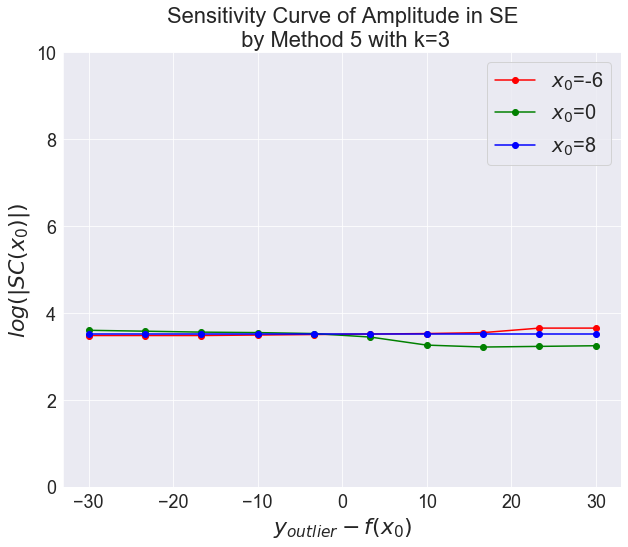

In [119]:
sc_kfold_cv(X1, Y1, noise, outliers, f_cos, 3, 'amp', para_set=np.linspace(5, 80, 200))

## SE covariance function using Method 5
## amplitude

[[19.64824120603015, 21.030150753768844, 22.688442211055275, 25.17587939698492, 27.93969849246231, 31.256281407035175, 35.678391959798994, 40.929648241206024, 46.18090452261306, 50.60301507537688], [5.0, 5.0, 5.0, 14.673366834170853, 26.281407035175878, 26.557788944723615, 6.105527638190955, 5.0, 5.0, 5.0], [22.412060301507537, 22.412060301507537, 22.412060301507537, 22.412060301507537, 22.412060301507537, 22.412060301507537, 22.412060301507537, 22.412060301507537, 22.412060301507537, 22.412060301507537]]
Finish the implementation in 7.9506 seconds


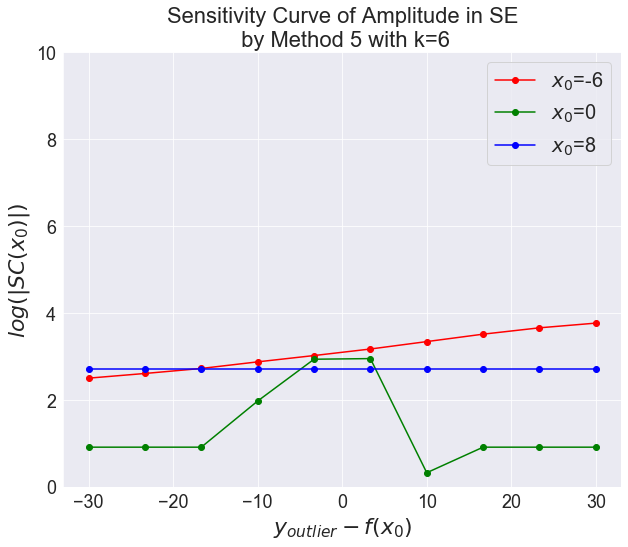

In [120]:
sc_kfold_cv(X1, Y1, noise, outliers, f_cos, 6, 'amp', para_set=np.linspace(5, 60, 200))

## SE covariance function using Method 5
## amplitude

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log


[[80.0, 80.0, 80.0, 80.0, 74.34673366834171, 64.9246231155779, 57.76381909547739, 53.24120603015076, 50.60301507537689, 49.84924623115578], [5.0, 5.7537688442211055, 37.788944723618094, 51.733668341708544, 71.70854271356784, 80.0, 75.85427135678393, 66.05527638190955, 5.376884422110553, 5.0], [74.72361809045226, 74.72361809045226, 74.72361809045226, 74.72361809045226, 74.72361809045226, 74.72361809045226, 74.72361809045226, 74.72361809045226, 74.72361809045226, 74.72361809045226]]
Finish the implementation in 13.8478 seconds


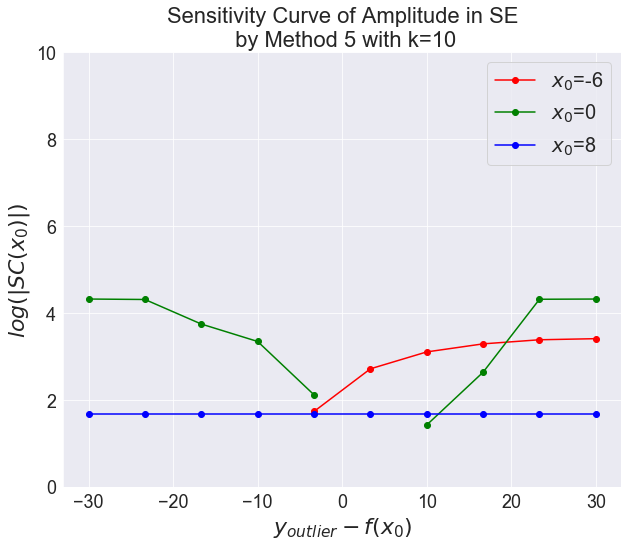

In [129]:
sc_kfold_cv(X1, Y1, noise, outliers, f_cos, 10, 'amp', para_set=np.linspace(5, 80, 200))

## Matern covariance function using Method 5
## length scale

[[4.555555555555555, 4.2727272727272725, 4.1313131313131315, 3.9898989898989896, 3.9898989898989896, 4.1313131313131315, 4.484848484848484, 5.191919191919192, 5.96969696969697, 6.747474747474747], [5.545454545454545, 5.262626262626263, 5.05050505050505, 4.838383838383838, 4.838383838383838, 4.909090909090909, 5.121212121212121, 5.404040404040404, 5.686868686868687, 6.04040404040404], [4.909090909090909, 4.909090909090909, 4.979797979797979, 4.979797979797979, 5.05050505050505, 5.05050505050505, 5.05050505050505, 5.121212121212121, 5.121212121212121, 5.121212121212121]]
Finish the implementation in 3.3748 seconds


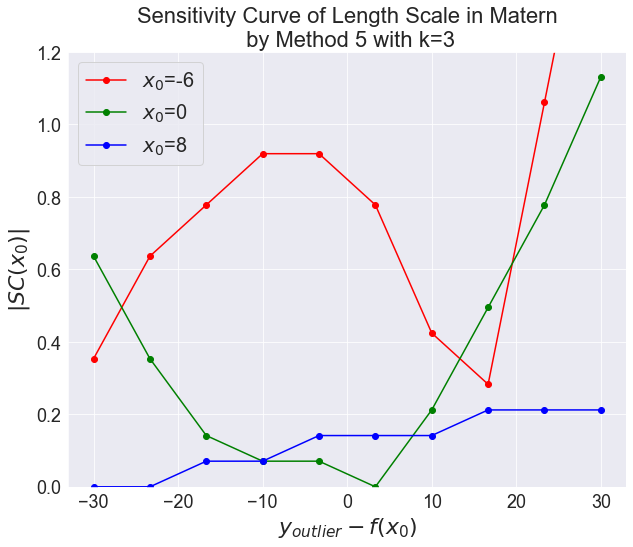

In [102]:
sc_kfold_cv(X1, Y1, noise, outliers, f_cos, 3, 'mal', para_set=np.linspace(3, 10,100))

[[4.979797979797979, 4.1313131313131315, 3.7777777777777777, 3.5656565656565657, 3.494949494949495, 3.494949494949495, 3.6363636363636362, 3.8484848484848486, 4.202020202020202, 4.696969696969697], [5.898989898989899, 5.686868686868687, 5.474747474747474, 5.262626262626263, 5.121212121212121, 4.979797979797979, 4.909090909090909, 4.909090909090909, 4.909090909090909, 4.979797979797979], [5.474747474747474, 5.545454545454545, 5.686868686868687, 5.757575757575758, 5.828282828282829, 5.898989898989899, 6.04040404040404, 6.111111111111111, 6.181818181818182, 6.252525252525253]]
Finish the implementation in 5.5424 seconds


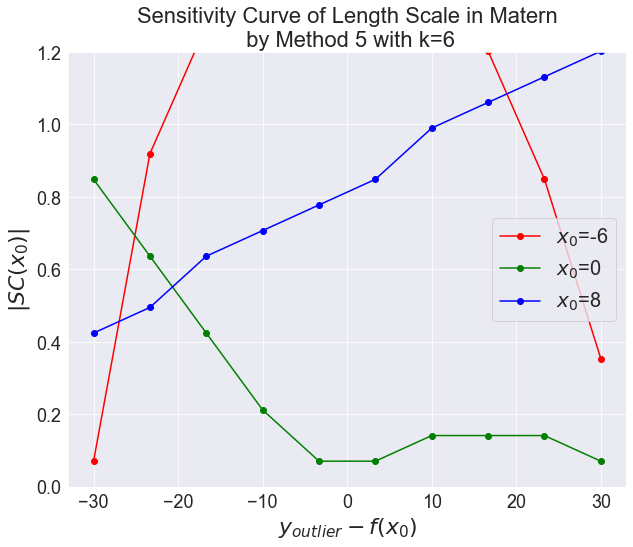

In [103]:
sc_kfold_cv(X1, Y1, noise, outliers, f_cos, 6, 'mal', para_set=np.linspace(3, 10,100))

[[4.909090909090909, 4.1313131313131315, 3.5656565656565657, 3.212121212121212, 3.0707070707070705, 3.0, 3.0707070707070705, 3.212121212121212, 3.4242424242424243, 3.7777777777777777], [4.979797979797979, 4.767676767676767, 4.555555555555555, 4.343434343434343, 4.2727272727272725, 4.202020202020202, 4.202020202020202, 4.202020202020202, 4.2727272727272725, 4.2727272727272725], [4.979797979797979, 5.191919191919192, 5.404040404040404, 5.545454545454545, 5.757575757575758, 5.898989898989899, 6.04040404040404, 6.181818181818182, 6.252525252525253, 6.393939393939394]]
Finish the implementation in 8.4528 seconds


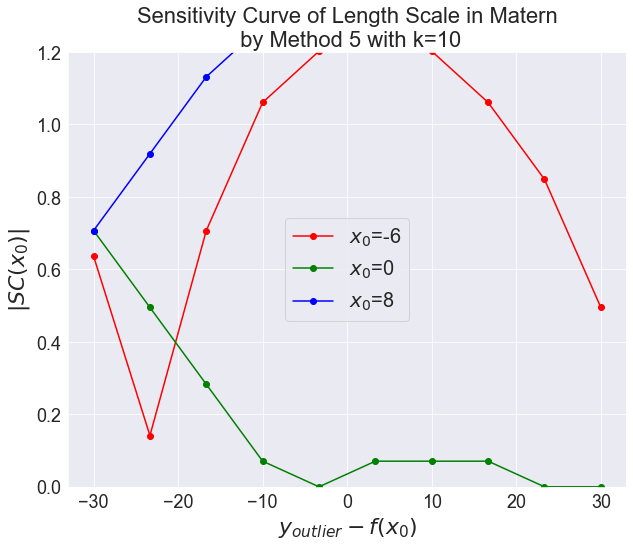

In [104]:
sc_kfold_cv(X1, Y1, noise, outliers, f_cos, 10, 'mal', para_set=np.linspace(3, 10,100))

## Gamma_exponential covariance function using Method 5
## length scale

[[4.626262626262626, 4.555555555555555, 4.484848484848484, 4.484848484848484, 4.414141414141414, 4.484848484848484, 4.626262626262626, 4.979797979797979, 5.686868686868687, 6.6767676767676765], [5.757575757575758, 5.474747474747474, 5.121212121212121, 4.909090909090909, 4.767676767676767, 4.838383838383838, 4.909090909090909, 5.191919191919192, 5.474747474747474, 5.828282828282829], [4.838383838383838, 4.909090909090909, 4.909090909090909, 4.979797979797979, 4.979797979797979, 4.979797979797979, 5.05050505050505, 5.05050505050505, 5.121212121212121, 5.121212121212121]]
Finish the implementation in 3.2937 seconds


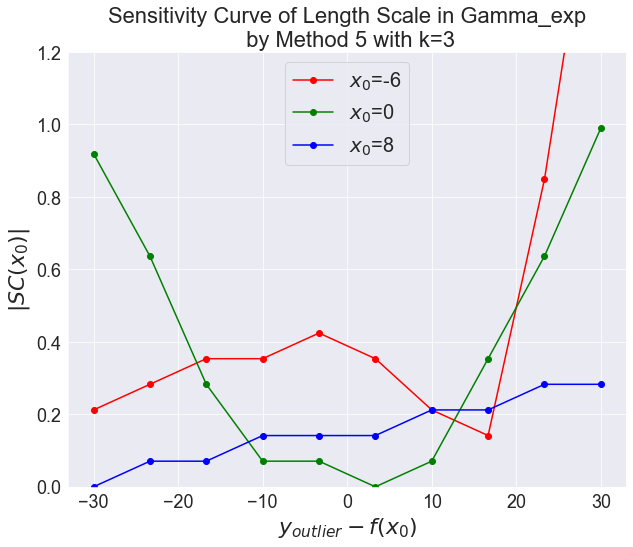

In [106]:
sc_kfold_cv(X1, Y1, noise, outliers, f_cos, 3, 'gaml', para_set=np.linspace(3, 10,100))

[[5.545454545454545, 4.979797979797979, 4.555555555555555, 4.343434343434343, 4.202020202020202, 4.2727272727272725, 4.343434343434343, 4.626262626262626, 5.05050505050505, 5.545454545454545], [6.3232323232323235, 6.111111111111111, 5.96969696969697, 5.828282828282829, 5.686868686868687, 5.616161616161616, 5.545454545454545, 5.616161616161616, 5.616161616161616, 5.686868686868687], [5.96969696969697, 6.111111111111111, 6.181818181818182, 6.252525252525253, 6.3232323232323235, 6.393939393939394, 6.4646464646464645, 6.535353535353535, 6.6060606060606055, 6.6060606060606055]]
Finish the implementation in 6.2521 seconds


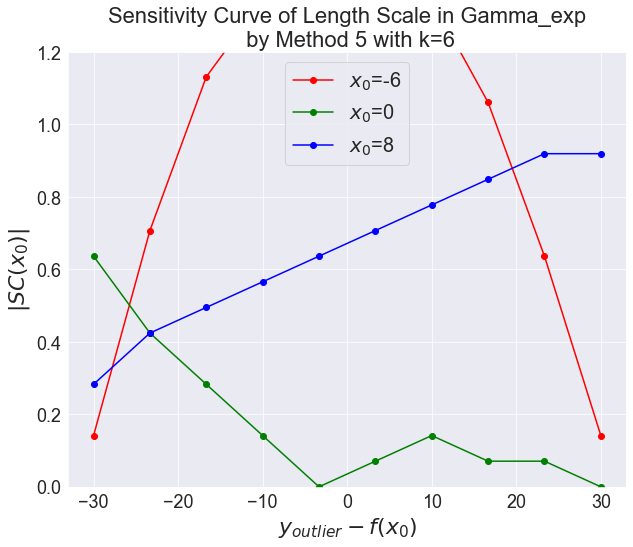

In [107]:
sc_kfold_cv(X1, Y1, noise, outliers, f_cos, 6, 'gaml', para_set=np.linspace(3, 10,100))

[[5.757575757575758, 4.979797979797979, 4.343434343434343, 3.919191919191919, 3.707070707070707, 3.6363636363636362, 3.6363636363636362, 3.8484848484848486, 4.1313131313131315, 4.555555555555555], [5.898989898989899, 5.686868686868687, 5.474747474747474, 5.262626262626263, 5.191919191919192, 5.121212121212121, 5.05050505050505, 5.121212121212121, 5.121212121212121, 5.191919191919192], [5.828282828282829, 6.04040404040404, 6.252525252525253, 6.393939393939394, 6.535353535353535, 6.6767676767676765, 6.818181818181818, 6.888888888888889, 7.03030303030303, 7.101010101010101]]
Finish the implementation in 12.6682 seconds


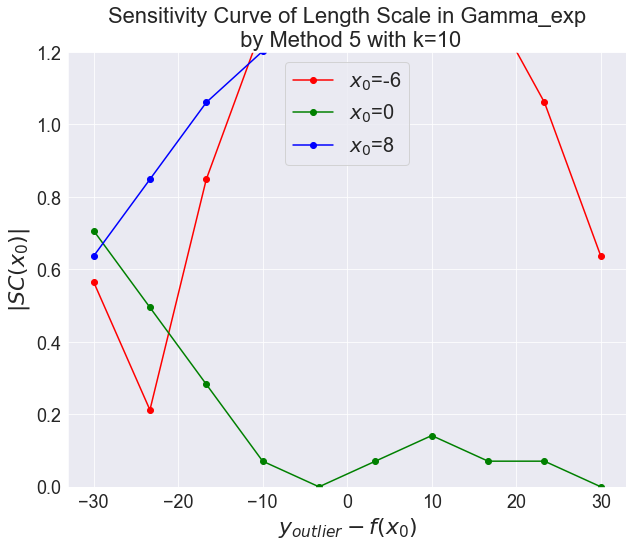

In [108]:
sc_kfold_cv(X1, Y1, noise, outliers, f_cos, 10, 'gaml', para_set=np.linspace(3, 10,100))

# optimal length scale for SE covarince function

In [131]:
optimum(X1, Y1, noise, 'l', para_set = [0.1,0.5,5,10,25,15,13],method1=neg_ll)

array([1.61420563])

# optimal amplitude for SE covarince function

In [132]:
optimum(X1, Y1, noise, 'amp', para_set = [0.8,1.0,80,3,100,300,40],method1=neg_ll)

array([13.29444454])

# optimal length scale for Matern_3 covarince function

In [133]:
optimum(X1, Y1, noise, 'mal', para_set = [0.5,0.8,1,1.2,1.4,1.6,1.8,1.9,2.0,2.1,2.2],method1=neg_ll)

array([1.9712626])

# optimal length scale for Gamma_exponential covarince function

In [130]:
optimum(X1, Y1, noise, 'gaml', para_set = [0.1,0.5,5,10,2.4,2.5,13,14,13.2,0.35,20],method1=neg_ll)

array([2.43295942])